In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily.

https://catalog.data.gov/dataset/consumer-complaint-database

In [12]:
path_to_zip_file='/content/drive/My Drive/Data/NLP/complaints.csv.zip'
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
%%time
df = pd.read_csv('/content/complaints.csv')

<string>:2: DtypeWarning: Columns (5,9,16) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 8.94 s, sys: 960 ms, total: 9.9 s
Wall time: 20.2 s


In [4]:
print(df.shape)
df.head()

(1531946, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2012-01-30,Credit card,NaN,Payoff process,NaN,NaN,NaN,BARCLAYS BANK DELAWARE,FL,33634,NaN,NaN,Web,2012-01-31,Closed with relief,Yes,No,18663
1,2013-08-07,Credit card,NaN,Billing disputes,NaN,NaN,NaN,"FIRST HAWAIIAN, INC.",HI,96816,NaN,NaN,Web,2013-08-07,Closed with explanation,Yes,No,482822
2,2011-12-01,Credit card,NaN,Billing disputes,NaN,NaN,NaN,"CITIBANK, N.A.",WA,98275,NaN,NaN,Web,2011-12-11,Closed with relief,Yes,No,2329
3,2013-05-16,Credit card,NaN,Billing disputes,NaN,NaN,NaN,DISCOVER BANK,LA,70809,NaN,NaN,Web,2013-05-17,Closed with explanation,Yes,No,409064
4,2013-02-19,Credit card,NaN,Credit reporting,NaN,NaN,NaN,SYNCHRONY FINANCIAL,VA,22546,NaN,NaN,Web,2013-02-21,Closed with non-monetary relief,Yes,No,318532


In [5]:

df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
print(df.shape)
df.head(10)

(511545, 2)


,narrative,Product
328,I have a Target credit card issued by TD Bank....,Credit card
351,"Hello, my name is XXXX. I am at my wits end. I...",Mortgage
361,"We went with the mortgage company, Guaranteed ...",Mortgage
780,New flood zone maps were being drawn up for ou...,Mortgage
878,My mortgage lender Chase has been providing me...,Mortgage
894,On XX/XX/2018 Santander repossessed my vehicle...,Vehicle loan or lease
975,I have been battling Selene Finance since XXXX...,Mortgage
996,I have been on an on Income Driven repayment p...,Student loan
999,1. ) Navient created obstacles to repayment by...,Student loan
1032,Please make this a rush as I have a sale sched...,Mortgage


In [6]:
#df.index = range(511545)
df.reset_index(drop=True,inplace=True)
df

,narrative,Product
0,I have a Target credit card issued by TD Bank....,Credit card
1,"Hello, my name is XXXX. I am at my wits end. I...",Mortgage
2,"We went with the mortgage company, Guaranteed ...",Mortgage
3,New flood zone maps were being drawn up for ou...,Mortgage
4,My mortgage lender Chase has been providing me...,Mortgage
...,...,...
511540,I closed on a HELOC loan with Pentagon Federal...,Mortgage
511541,"To whom it may concern, I had applied for a pe...","Payday loan, title loan, or personal loan"
511542,I have a mortgage with Specialized Loan Servic...,Mortgage
511543,"SCREENING REPORTS, obtained my background chec...","Credit reporting, credit repair services, or o..."


In [7]:
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

100697752

We have over 100 million words, it is not a small data set (update 2020)

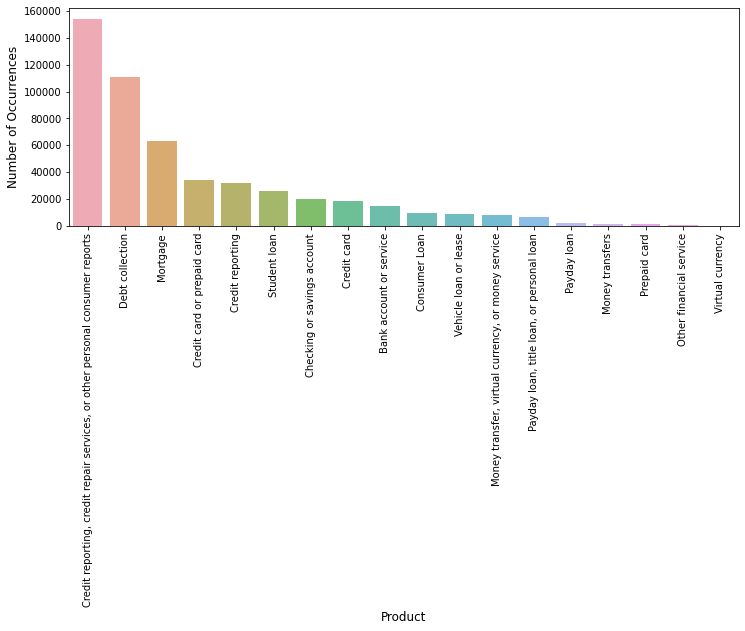

In [8]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The classes are imbalanced. However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

Let's have a look a few examples of complaint narrative and its associated product.

In [9]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [10]:
print_complaint(12)

XXXX XXXX company is reporting information on my credit report that is not my account this information is not true by law they cant do it
Product: Credit reporting, credit repair services, or other personal consumer reports


In [11]:
print_complaint(20)

1. XX/XX/XXXX. Began employment at the facility in XXXX, TX. Signed relocation package valued at {$12000.00}, ( exhibit 1 ).

2. XX/XX/XXXX. Relocated to the facility in XXXX, TX. Signed relocation package valued at {$12000.00}, ( exhibit 2 ). 
2a. As noted in both relocation packages, the relocation to XXXX nullified the original relocation commitment. 
3. During the summer of XXXX, I was temporally travelling back to and forth the XXXX, TX facility to work on equipment. During these times, I would still report to my assigned location of XXXX, TX to get a company truck and drive to XXXX. During that time, I would also return to XXXX on the weekend, and at the end of the hitch. There was no change in my reporting structure, as this was a temporary assignment. 
4. In XXXX of XXXX, I was told I was being dedicated to XXXX. From that point forward, I began reporting directly to the XXXX, TX, facility as opposed to the XXXX facility I had been assigned to. My job function had substantially

### Text preprocessing

Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [12]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [13]:
df['narrative'][20]

'1. //. began employment at the facility in , t. signed relocation package valued at {$12000.00}, ( ehibit 1 ).\n\n2. //. relocated to the facility in , t. signed relocation package valued at {$12000.00}, ( ehibit 2 ). \n2a. as noted in both relocation packages, the relocation to  nullified the original relocation commitment. \n3. during the summer of , i was temporally travelling back to and forth the , t facility to work on equipment. during these times, i would still report to my assigned location of , t to get a company truck and drive to . during that time, i would also return to  on the weekend, and at the end of the hitch. there was no change in my reporting structure, as this was a temporary assignment. \n4. in  of , i was told i was being dedicated to . from that point forward, i began reporting directly to the , t, facility as opposed to the  facility i had been assigned to. my job function had substantially changed, as i was no longer covering fleets in the field as i had be

The following steps include train/test split of 70/30, remove stop-words and tokenize text using NLTK tokenizer. For our first try we tag every complaint narrative with its product.

In [14]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [15]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

This is what a training entry looks like - an example complaint narrative tagged by 'Credit reporting'.

In [ ]:
train_tagged[:5]

In [ ]:
train_tagged.values[30]

TaggedDocument(words=['had', 'bankruptcy', 'years', 'ago', 'and', 'it', 'is', 'still', 'showing', 'up', 'on', 'equifa', 'which', 'is', 'preventing', 'me', 'from', 'buying', 'home', 'at', 'good', 'rate', 'they', 'need', 'to', 'take', 'it', 'off', 'like', 'did', 'so', 'my', 'score', 'will', 'be'], tags=['Credit reporting'])

## Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

### DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

We set the minimum word count to 2 in order to discard words with very few occurrences. 

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()

Build a vocabulary

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 223102/223102 [00:00<00:00, 2855261.21it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), 
                     total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 223102/223102 [00:00<00:00, 2033057.94it/s]


Wall time: 18min 24s


### Buliding the final vector feature for the classifier.

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], 
                                 model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6683609437751004
Testing F1 score: 0.651646431211616


### Distributed Memory with Averaging

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.
We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [ ]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 223102/223102 [00:00<00:00, 1886113.74it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 223102/223102 [00:00<00:00, 2778023.03it/s]


Wall time: 33min 28s


### Train Logistic Regression

In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.47498326639892907
Testing F1 score: 0.4445833078167434


In [ ]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [ ]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6778572623828648
Testing F1 score: 0.664561533967402
